## Cognitive Battery Introduction: Jax-3DP3

In [1]:
import os
import numpy as np
import jax3dp3
from jax3dp3.viz import (
    get_depth_image,
    multi_panel,
)
from jax3dp3.transforms_3d import transform_from_pos, depth_to_coords_in_camera
import jax.numpy as jnp
import jax
from scipy.spatial.transform import Rotation as R
from jax3dp3.viz import make_gif_from_pil_images
from PIL import Image
import trimesh
from tqdm import tqdm

import cog_utils as utils

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
scene = "swap"
data_path = f"/home/khaledshehada/cog_jax3dp3_data/{scene}_data/videos/"
num_frames = len(os.listdir(os.path.join(data_path, "frames")))

In [3]:
width = 300
height = 300
fov = 90

fx, fy, cx, cy = utils.get_camera_intrinsics(width, height, fov)

fx_fy = jnp.array([fx, fy])
cx_cy = jnp.array([cx, cy])
near, far = 0.001, 50.0
K = jnp.array(
    [
        [fx_fy[0], 0.0, cx_cy[0]],
        [0.0, fx_fy[1], cx_cy[1]],
        [0.0, 0.0, 1.0],
    ]
)

jax3dp3.setup_renderer(height, width, fx, fy, cx, cy, near, far)

Increasing frame buffer size to (width, height, depth) = (320, 320, 2048)


In [4]:
rgb_images, depth_images, seg_maps = [], [], []
rgb_images_pil = []
for i in range(num_frames):
    rgb_path = os.path.join(data_path, f"frames/frame_{i}.jpeg")
    if not os.path.isfile(rgb_path):
        rgb_path = rgb_path.replace("jpeg", "png")
    rgb_img = Image.open(rgb_path)
    rgb_images_pil.append(rgb_img)
    rgb_images.append(np.array(rgb_img))

    depth_path = os.path.join(data_path, f"depths/frame_{i}.npy")
    depth_npy = np.load(depth_path)
    depth_images.append(depth_npy)

    seg_map = np.load(os.path.join(data_path, f"segmented/frame_{i}.npy"))
    seg_maps.append(seg_map)

In [5]:
coord_images = []  # depth data in 2d view as images
seg_images = []  # segmentation data as images

for frame_idx in range(num_frames):
    coord_image, _ = depth_to_coords_in_camera(depth_images[frame_idx], K)
    segmentation_image = seg_maps[frame_idx].copy()
    mask = np.invert(
        (coord_image[:, :, 0] < 2.0)
        * (coord_image[:, :, 0] > -1)
        * (coord_image[:, :, 1] < 0.463)
        * (coord_image[:, :, 1] > -0.8)
        * (coord_image[:, :, 2] < 1.8)
        * (coord_image[:, :, 2] > 0.25)
    )
    coord_image[mask, :] = 0.0
    segmentation_image[mask, :] = 0.0
    coord_images.append(coord_image)
    seg_images.append(segmentation_image)

coord_images = np.stack(coord_images)
seg_images = np.stack(seg_images)

In [6]:
# Load meshes
meshes = []
meshes_path = data_path.replace("videos", "meshes")
for mesh_name in os.listdir(meshes_path):
    if not mesh_name.endswith(".obj"): continue
    mesh_path = os.path.join(meshes_path, mesh_name)
    mesh = trimesh.load(mesh_path, force="mesh")
    jax3dp3.load_model(mesh)
    meshes.append(mesh_name.replace(".obj", ""))
    print(meshes[-1])

apple
mug


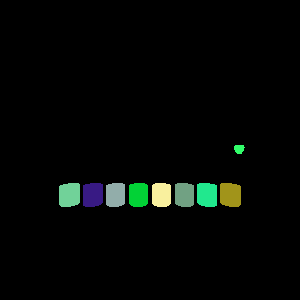

In [7]:
start_t = 11
seg_img = seg_images[start_t]

Image.fromarray(seg_img)

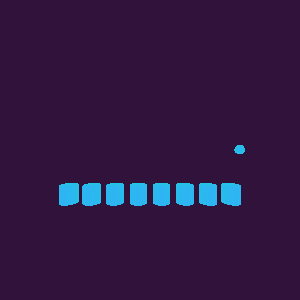

In [8]:
num_objects = 10
indices, init_poses = [], []
obj_ids = jnp.unique(seg_img.reshape(-1, 3), axis=0)
obj_ids = sorted(
    obj_ids, key=lambda x: jnp.all(seg_img == x, axis=-1).sum(), reverse=True
)
for obj_id in obj_ids[: num_objects + 1]:
    if jnp.all(obj_id == 0):
        # Background
        continue

    obj_mask = jnp.all(seg_img == obj_id, axis=-1)
    masked_depth = coord_images[start_t].copy()
    masked_depth[~obj_mask] = 0

    object_points = coord_images[start_t][obj_mask]
    maxs = np.max(object_points, axis=0)
    mins = np.min(object_points, axis=0)
    dims = maxs - mins
    obj_center = (maxs + mins) / 2
    obj_transform = transform_from_pos(obj_center)

    best = utils.find_best_mesh(meshes, obj_transform, masked_depth)
    if best:
        indices.append(best[0])
        init_poses.append(best[1])

init_poses = jnp.array(init_poses)
rendered_image = jax3dp3.render_multiobject(init_poses, indices)
get_depth_image(rendered_image[:, :, 2], max=5)

In [9]:
# Liklihood parameters
r = radius = 0.1
outlier_prob = 0.01
outlier_volume = 1

# Enumeration parameters
n = 6  # number of enumerated proposals on each dimension (x, y, z).
d = 0.05  # the minimum and maximum position delta on each dimension (x, y, z).

# Enumerating proposals
translation_deltas_global = jax3dp3.make_translation_grid_enumeration(
    -d, -d, -d, d, d, d, n, n, n
)

reward_d = 0.3
translation_deltas_reward = jax3dp3.make_translation_grid_enumeration(
    -reward_d, -reward_d, -reward_d, reward_d, reward_d, reward_d, n, n, n
)


def scorer(rendered_image, gt, prior):
    weight = jax3dp3.likelihood.threedp3_likelihood(
        gt, rendered_image, r, outlier_prob, outlier_volume
    )
    return prior * weight


scorer_parallel = jax.vmap(scorer, in_axes=(0, None, 0))
scorer_parallel_jit = jax.jit(scorer_parallel)

6. Define the liklihood methods and the proposal enumerations.

In [10]:
# Liklihood parameters
r = radius = 0.1
outlier_prob = 0.005
outlier_volume = 0.5

# Enumeration parameters
n = 7  # number of enumerated proposals on each dimension (x, y, z).
d = 0.05  # the minimum and maximum position delta on each dimension (x, y, z).

# Enumerating proposals
translation_deltas_global = jax3dp3.make_translation_grid_enumeration(
    -d, -d, -d, d, d, d, n, n, n
)

reward_d = 0.3
translation_deltas_reward = jax3dp3.make_translation_grid_enumeration(
    -reward_d, -reward_d, -reward_d, reward_d, reward_d, reward_d, n, n, n
)
reward_deltas_mask = jnp.abs(translation_deltas_reward[:, -2, -1]) > 1e-6
translation_deltas_reward = translation_deltas_reward.at[reward_deltas_mask, -2, -1].set(0)


def scorer(rendered_image, gt, prior):
    weight = jax3dp3.likelihood.threedp3_likelihood(
        gt, rendered_image, r, outlier_prob, outlier_volume
    )
    return prior * weight


scorer_parallel = jax.vmap(scorer, in_axes=(0, None, 0))
scorer_parallel_jit = jax.jit(scorer_parallel)

In [11]:
pose_estimates = init_poses.copy()
t = start_t
gt_image = jnp.array(coord_images[t])

translation_deltas = translation_deltas_global
translation_deltas_full = jnp.tile(
    jnp.eye(4)[None, :, :],
    (translation_deltas.shape[0], pose_estimates.shape[0], 1, 1),
)
translation_deltas_full = translation_deltas_full.at[:, 0, :, :].set(translation_deltas)
translation_proposals = jnp.einsum(
    "bij,abjk->abik", pose_estimates, translation_deltas_full
)
images = jax3dp3.render_parallel(translation_proposals, 0)
prior = jnp.ones((translation_deltas.shape[0],))
weights_new = scorer_parallel_jit(images, gt_image, prior)
pose_estimates = translation_proposals[jnp.argmax(weights_new)]

In [12]:
num_steps = num_frames - start_t
num_steps = 30
inferred_poses = []
n_objects = pose_estimates.shape[0]
reward_idx = n_objects - 1

containment_relations = {}
objs_deltas = {}

pose_estimates = init_poses.copy()
for t in tqdm(range(start_t, start_t + num_steps)):
    gt_image = jnp.array(coord_images[t])    
    for i in range(n_objects):
        translation_deltas = translation_deltas_global if i != reward_idx else translation_deltas_reward
        # Check for occlusion
        if i == reward_idx:
            occluded = utils.check_occlusion(pose_estimates, indices, i)
            if occluded:
                prior = jnp.ones((translation_deltas.shape[0],))
                containing_obj = utils.check_containment(pose_estimates, indices, i)
                if containing_obj is not None:
                    containment_relations[containing_obj] = i # TODO: extend to list of contained objs
                    continue
            else:
                prior = jnp.ones((translation_deltas.shape[0],))
        
        pose_estimate = pose_estimates[i]
        translation_proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
        images = jax3dp3.render_parallel(translation_proposals, indices[i])
        weights_new = scorer_parallel_jit(images, gt_image, prior)
        best_weight_idx = jnp.argmax(weights_new)
        old_pose = pose_estimate.copy()
        pose_estimate = translation_proposals[best_weight_idx]
        # objs_deltas[i] = translation_deltas[best_weight_idx]
        objs_deltas[i] = pose_estimate - old_pose
        pose_estimates = pose_estimates.at[i].set(pose_estimate)
    
    for i, j in containment_relations.items():
        new_pose_estimate = pose_estimates[j] + objs_deltas[i]
        pose_estimates = pose_estimates.at[j].set(new_pose_estimate)
        
    inferred_poses.append(pose_estimates.copy())

100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


In [13]:
all_images = []
for t in tqdm(range(start_t, start_t + num_steps)):
    rgb_viz = Image.fromarray(rgb_images[t].astype(np.int8), mode="RGB")
    gt_depth_1 = get_depth_image(coord_images[t][:, :, 2], max=5.0)
    poses = inferred_poses[t - start_t]
    rendered_image = jax3dp3.render_multiobject(poses, indices)
    rendered_image = get_depth_image(rendered_image[:, :, 2], max=5)

    apple_pose = poses[-1]
    rendered_apple = jax3dp3.render_single_object(apple_pose, indices[-1])
    rendered_apple = [get_depth_image(rendered_apple[:, :, 2], max=5)]
    
    # rendered_apple = []
    # for i in range(len(poses)):
    #     render = jax3dp3.render_single_object(poses[i], indices[i])
    #     rendered_apple.append(get_depth_image(render[:, :, 2], max=5))
    all_images.append(
        multi_panel(
            [rgb_viz, gt_depth_1, rendered_image, *rendered_apple],
            [
                f"\nRGB Image",
                f"   Frame: {t}\nActual Depth",
                "\nReconstructed Depth",
                *(["\nApple Only"] * len(rendered_apple)),
            ],
            # [f"RGB Image", f"Actual Depth", "Reconstructed Depth", "Reconstructed (Apple Only)"],
            middle_width=10,
            label_fontsize=20,
        )
    )
out_path = f"{scene}_out.gif"
make_gif_from_pil_images(all_images, out_path)
print("Saved output to:", out_path)

100%|██████████| 30/30 [00:02<00:00, 12.47it/s]


Saved output to: swap_out.gif
